# Chicago Gang & Socioeconomic Analysis

This notebook analyzes the prescence of gangs in Chicago neighborhoods and overlays violent crime, education, and other socioeconomic data to understand the relationship between gang presence and certain socioeconomic factors.

*Note*
I wanted to calculate crime rates in neighborhoods on a per capita basis, but I was unable to find a data set that would link population totals to specific neighborhoods and gang territories. 
Instead the crime rates are based on crime rate per square mile.

**Objectives**:
- Overlay violent crime rates with gang territories.
- Find highest crime density in specific gang territories.
- Map out the amount of different gangs in each Chicago neighborhood.
- Test to see if there is more crime in neighborhoods with a higher number of different gangs. 
- Track abandoned building rates in neighborhoods with high gang presence.
- Evaluate graduation rates in neighborhoods with high gang presence vs neighborhoods with a low gang presence.

In [ ]:
#Remove hashtag from the line below if you have not installed the packages.
#%pip install pandas geopandas folium matplotlib seaborn requests numpy


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [19]:
# Import Libraries
import pandas as pd
import geopandas as gpd
import folium
import requests
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import Point

%matplotlib inline

In [8]:
# 1. Load Gang Boundaries
gang_file = '2024_Gang_Boundaries.geojson'
try:
    gangs_gdf = gpd.read_file(gang_file)
    print(f"Loaded {len(gangs_gdf)} gang territories.")
except Exception as e:
    print(f"Error loading gang file: {e}")

Loaded 46 gang territories.


In [9]:
# 2. Fetch Crime Data (API)
print("Fetching crime data...")
base_url = "https://data.cityofchicago.org/resource/dqcy-ctma.json"
params = {
    "$limit": 20000,
    "$order": "date DESC",
    "$where": "latitude IS NOT NULL AND longitude IS NOT NULL"
}
response = requests.get(base_url, params=params)
data = response.json()
crime_df = pd.DataFrame(data)
print(f"Fetched {len(crime_df)} records.")

Fetching crime data...
Fetched 20000 records.


In [10]:
# 3. Process Data
# Filter for violent crimes
violent_types = ['HOMICIDE', 'BATTERY', 'ASSAULT', 'ROBBERY', 'CRIMINAL SEXUAL ASSAULT', 'SEX OFFENSE']
vio_crimes = crime_df[crime_df['primary_type'].isin(violent_types)].copy()

# Convert lat/lon to numeric
vio_crimes['latitude'] = pd.to_numeric(vio_crimes['latitude'])
vio_crimes['longitude'] = pd.to_numeric(vio_crimes['longitude'])

# Create GeoDataFrame
geometry = [Point(xy) for xy in zip(vio_crimes['longitude'], vio_crimes['latitude'])]
crimes_gdf = gpd.GeoDataFrame(vio_crimes, crs="EPSG:4326", geometry=geometry)
print(f"Filtered to {len(crimes_gdf)} violent crimes.")

Filtered to 6229 violent crimes.


In [11]:
# 4. Spatial Join & Analysis
# Ensure CRS match
if gangs_gdf.crs != crimes_gdf.crs:
    gangs_gdf = gangs_gdf.to_crs(crimes_gdf.crs)

# Join crimes to gangs
joined = gpd.sjoin(crimes_gdf, gangs_gdf, how="inner", predicate="within")

# Aggregate counts
counts = joined.groupby('GANG_NAME').size().reset_index(name='crime_count')

# Merge back to gangs_gdf
gangs_analyzed = gangs_gdf.merge(counts, on='GANG_NAME', how='left')
gangs_analyzed['crime_count'] = gangs_analyzed['crime_count'].fillna(0)

# Calculate Density (needs projected CRS for area)
# Using EPSG:3857 (Web Mercator) for meters -> sq km
gangs_proj = gangs_analyzed.to_crs(epsg=3857)
gangs_analyzed['area_sqkm'] = gangs_proj.area / 10**6
gangs_analyzed['crime_density'] = gangs_analyzed['crime_count'] / gangs_analyzed['area_sqkm']

display(gangs_analyzed[['GANG_NAME', 'crime_count', 'crime_density']].sort_values('crime_density', ascending=False).head())

GANG_NAME  crime_count  crime_density
16             PARTY PEOPLE         10.0      25.065683
24             TWO-TWO BOYS          4.0      24.196726
8   MAFIA INSANE VICE LORDS         51.0      18.432751
37     FOUR CORNER HUSTLERS        206.0      16.380755
27               VICE LORDS          4.0      15.685255

# 5. Interactive Map

This map will highlight each individual gang territory in Chicago, and the color of the territory will correspond to the violent crime density of that territory. If you would like to hover over a territory, you can see the gang that controls that territory and the violent crime density of that territory, the amount of violent crimes committed in that territory, and the crime density ratio of that territory.

In [ ]:

m = folium.Map(location=[41.8781, -87.6298], zoom_start=11)

# Add Choropleth
folium.Choropleth(
    geo_data=gangs_analyzed,
    name='Crime Density',
    data=gangs_analyzed,
    columns=['GANG_NAME', 'crime_density'],
    key_on='feature.properties.GANG_NAME',
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Violent Crimes per Sq Km'
).add_to(m)

# Add Tooltips
folium.GeoJson(
    gangs_analyzed,
    style_function=lambda x: {'fillColor': '#ffffff00', 'color': '#ffffff00'}, # Invisible polygons for tooltip
    tooltip=folium.GeoJsonTooltip(
        fields=['GANG_NAME', 'crime_count', 'crime_density'],
        aliases=['Gang:', 'Count:', 'Density:'],
        localize=True
    )
).add_to(m)

folium.LayerControl().add_to(m)
m

# 6. Bar Charts of Violent Crime Density in Specific Gang Territories

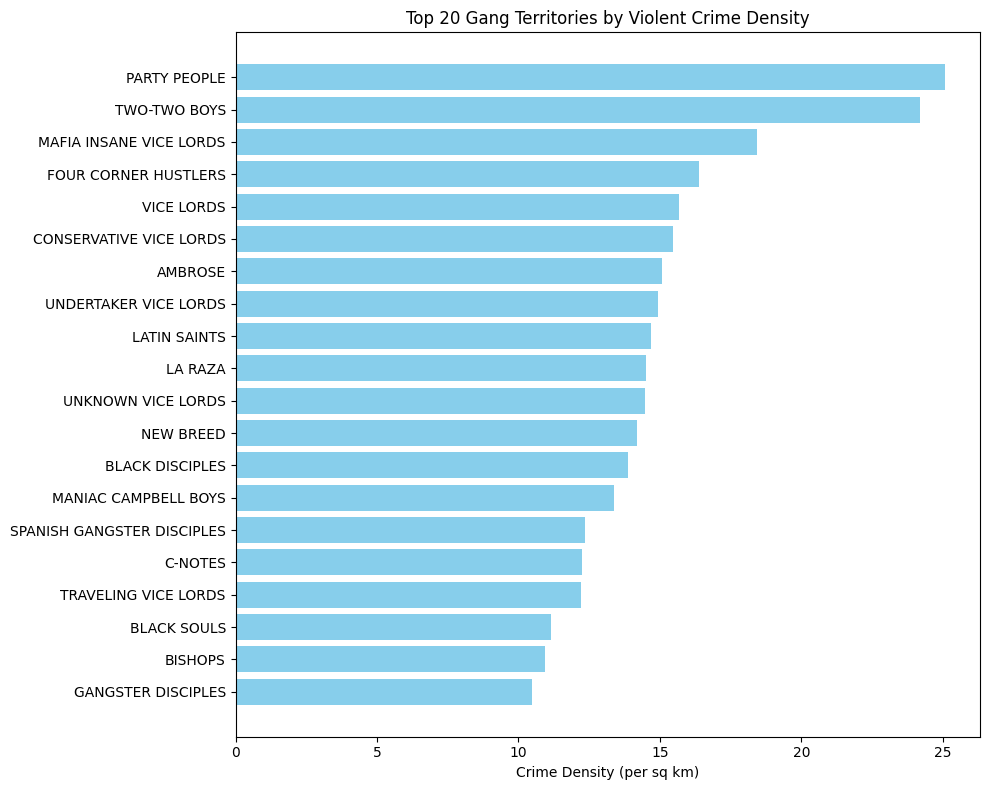

In [ ]:

top_gangs = gangs_analyzed[gangs_analyzed['crime_count'] > 0].sort_values('crime_density', ascending=True).tail(20)

plt.figure(figsize=(10, 8))
plt.barh(top_gangs['GANG_NAME'], top_gangs['crime_density'], color='skyblue')
plt.xlabel('Crime Density (per sq km)')
plt.title('Top 20 Gang Territories by Violent Crime Density')
plt.tight_layout()
plt.show()

# 7. Gang Plurality Analysis
This section analyzes which neighborhoods have the most diverse gang presence (number of unique gangs).

In [14]:
# Load Neighborhoods
neighborhoods_file = 'chicago_neighborhoods.geojson'
neighborhoods = gpd.read_file(neighborhoods_file)

# Spatial Join: Neighborhoods and Gangs
if neighborhoods.crs != gangs_gdf.crs:
    neighborhoods = neighborhoods.to_crs(gangs_gdf.crs)

# Join to find intersections
neigh_gang_join = gpd.sjoin(neighborhoods, gangs_gdf, how='inner', predicate='intersects')

# Count unique gangs per neighborhood
diversity_counts = neigh_gang_join.groupby('pri_neigh')['GANG_NAME'].nunique().reset_index(name='unique_gang_count')

# Merge back to neighborhood boundaries
neighborhoods_diversity = neighborhoods.merge(diversity_counts, on='pri_neigh', how='left')
neighborhoods_diversity['unique_gang_count'] = neighborhoods_diversity['unique_gang_count'].fillna(0)

print("Top 5 Neighborhoods by Gang Diversity:")
print(neighborhoods_diversity[['pri_neigh', 'unique_gang_count']].sort_values('unique_gang_count', ascending=False).head())

# Visualize Gang Diversity
m_diversity = folium.Map(location=[41.8781, -87.6298], zoom_start=11)

# Fix: Drop unnecessary columns that might cause serialization errors (e.g. Timestamps)
neighborhoods_viz = neighborhoods_diversity[['pri_neigh', 'unique_gang_count', 'geometry']].copy()

folium.Choropleth(
    geo_data=neighborhoods_viz,
    name='Gang Diversity',
    data=neighborhoods_diversity,
    columns=['pri_neigh', 'unique_gang_count'],
    key_on='feature.properties.pri_neigh',
    fill_color='PuBuGn',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Number of Unique Gangs'
).add_to(m_diversity)

folium.GeoJson(
    neighborhoods_viz,
    style_function=lambda x: {'fillColor': '#ffffff00', 'color': '#ffffff00'},
    tooltip=folium.GeoJsonTooltip(
        fields=['pri_neigh', 'unique_gang_count'],
        aliases=['Neighborhood:', 'Unique Gangs:'],
        localize=True
    )
).add_to(m_diversity)

folium.LayerControl().add_to(m_diversity)
m_diversity


Top 5 Neighborhoods by Gang Diversity:
         pri_neigh  unique_gang_count
4    Humboldt Park               13.0
94          Austin               12.0
18        New City                9.0
93  Belmont Cragin                8.0
61   South Chicago                8.0


# 8. Correlation: Gang Plularility vs Violent Crime
Does having more unique gangs in a neighborhood correlate with higher violent crime rates?

Correlation between Gang Diversity (Unique Gangs) and Violent Crime Density: -0.0255


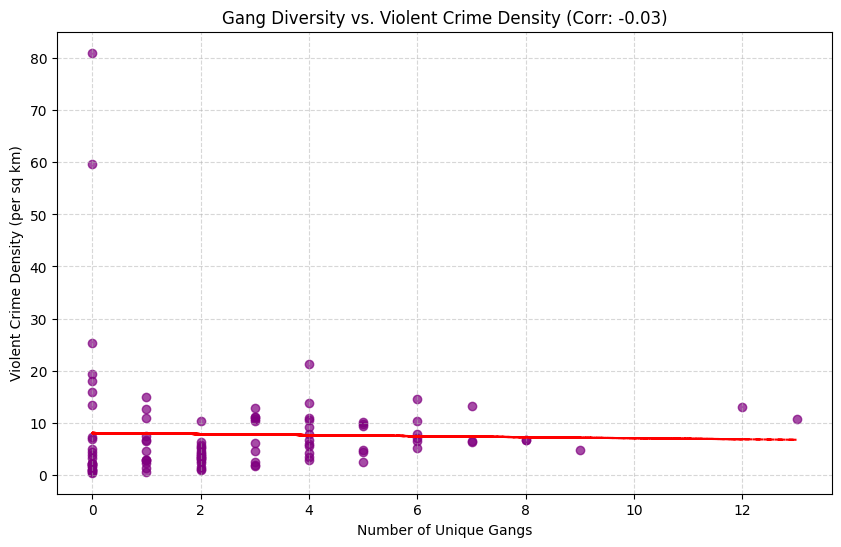

Median Gang Count: 2.0
Mean Crime Density by Plurality Status:
plurality_status
High Plurality    7.955099
Low Plurality     7.609595
Name: crime_density, dtype: float64


/var/folders/6c/5mxktr117wn2z16dqvjh_jjw0000gn/T/ipykernel_70927/1942744411.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='plurality_status', y='crime_density', data=neigh_stats, palette="Set2")


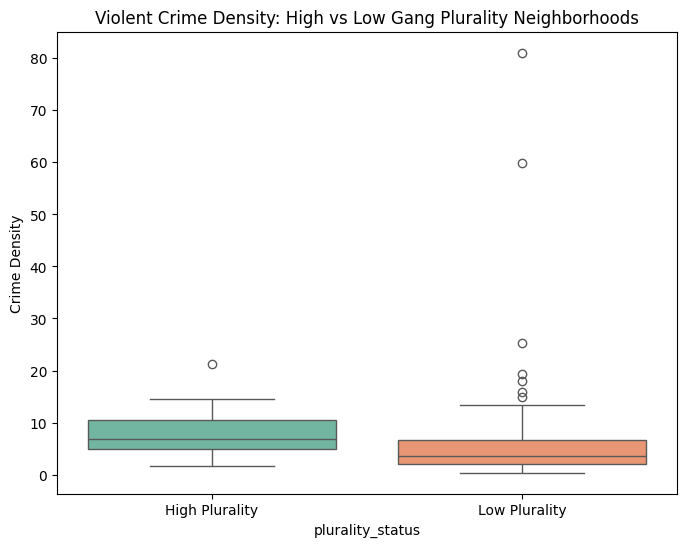

In [20]:
# 1. Spatially Join Crimes to Neighborhoods
if neighborhoods_diversity.crs != crimes_gdf.crs:
    crimes_gdf = crimes_gdf.to_crs(neighborhoods_diversity.crs)

# Join crimes to neighborhoods
crimes_neigh = gpd.sjoin(crimes_gdf, neighborhoods_diversity, how='inner', predicate='within')

# Count crimes per neighborhood
crime_counts_neigh = crimes_neigh.groupby('pri_neigh').size().reset_index(name='neigh_crime_count')

# Merge crime counts back to neighborhoods_diversity
neigh_stats = neighborhoods_diversity.merge(crime_counts_neigh, on='pri_neigh', how='left')
neigh_stats['neigh_crime_count'] = neigh_stats['neigh_crime_count'].fillna(0)

# Calculate Area (sq km) using projected CRS (EPSG:3857)
neigh_proj = neigh_stats.to_crs(epsg=3857)
neigh_stats['area_sqkm'] = neigh_proj.area / 10**6

# Calculate Crime Density (crimes / sq km)
neigh_stats['crime_density'] = neigh_stats['neigh_crime_count'] / neigh_stats['area_sqkm']

# 2. Correlation
correlation = neigh_stats['unique_gang_count'].corr(neigh_stats['crime_density'])
print(f"Correlation between Gang Diversity (Unique Gangs) and Violent Crime Density: {correlation:.4f}")

# 3. Visualization
plt.figure(figsize=(10, 6))
plt.scatter(neigh_stats['unique_gang_count'], neigh_stats['crime_density'], alpha=0.7, color='purple')
plt.title(f'Gang Diversity vs. Violent Crime Density (Corr: {correlation:.2f})')
plt.xlabel('Number of Unique Gangs')
plt.ylabel('Violent Crime Density (per sq km)')
plt.grid(True, linestyle='--', alpha=0.5)

# Add trendline
import numpy as np
z = np.polyfit(neigh_stats['unique_gang_count'], neigh_stats['crime_density'], 1)
p = np.poly1d(z)
plt.plot(neigh_stats['unique_gang_count'], p(neigh_stats['unique_gang_count']), "r--")

plt.show()

# Classification: High vs Low Plurality
# Let's define High Plurality as > Median, Low as <= Median
median_gangs = neigh_stats['unique_gang_count'].median()
neigh_stats['plurality_status'] = neigh_stats['unique_gang_count'].apply(lambda x: 'High Plurality' if x > median_gangs else 'Low Plurality')

print(f"Median Gang Count: {median_gangs}")
print("Mean Crime Density by Plurality Status:")
print(neigh_stats.groupby('plurality_status')['crime_density'].mean())

plt.figure(figsize=(8, 6))
sns.boxplot(x='plurality_status', y='crime_density', data=neigh_stats, palette="Set2")
plt.title('Violent Crime Density: High vs Low Gang Plurality Neighborhoods')
plt.ylabel('Crime Density')
plt.show()


This is where having per capita data would be more insightful, but I believe that density still provides a good insights. The boxplot shows that ares with high gang plurality have a higher average crime density, but the correlation is not strong as many of the areas with the highest violent crime density are in the low gang plurality neighborhoods. 

# 9. City Territory Analysis
Percentage of Chicago that is Gang Territory vs Not.

Chicago Territory Analysis:
             Category   Area_SqKm  Percentage
0      Gang Territory  288.948892   26.795376
1  Not Gang Territory  789.404672   73.204624


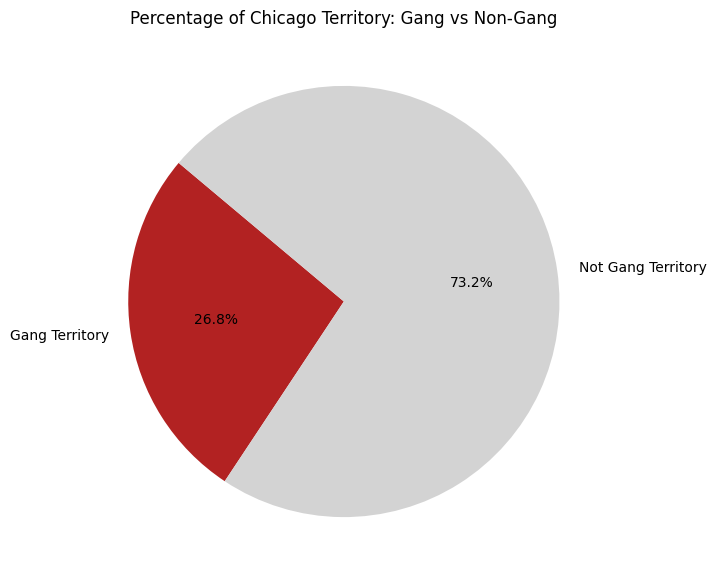

In [16]:
# Calculate Total City Area (Sums of neighborhoods)
# Use EPSG:3857 for accurate area calculation in meters -> sq km
city_area = neighborhoods.to_crs(epsg=3857).area.sum() / 10**6

# Calculate Gang Territory Area
# Dissolve all gang boundaries to handle overlaps and get true union area
gang_union = gangs_gdf.to_crs(epsg=3857).dissolve()
gang_area = gang_union.area.sum() / 10**6

# Non-Gang Area
non_gang_area = city_area - gang_area

# Create DataFrame
territory_df = pd.DataFrame({
    'Category': ['Gang Territory', 'Not Gang Territory'],
    'Area_SqKm': [gang_area, non_gang_area],
    'Percentage': [gang_area/city_area * 100, non_gang_area/city_area * 100]
})

print("Chicago Territory Analysis:")
print(territory_df)

# Pie Chart
plt.figure(figsize=(7, 7))
plt.pie(territory_df['Percentage'], labels=territory_df['Category'], autopct='%1.1f%%', colors=['firebrick', 'lightgray'], startangle=140)
plt.title('Percentage of Chicago Territory: Gang vs Non-Gang')
plt.show()


This pie chart is to set up the next section. Take note of these percentages.

# 10. Abandoned Buildings Correlation
Analyzing the correlation between gang territories and abandoned buildings (311 reports).

Abandoned Buildings Location Analysis:
                Location  Count  Percentage
0  Inside Gang Territory  42056   64.256684
1                Outside  23394   35.743316


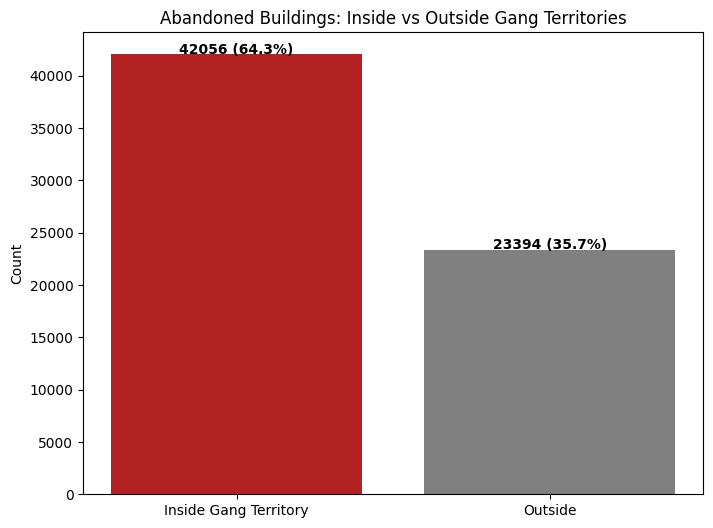

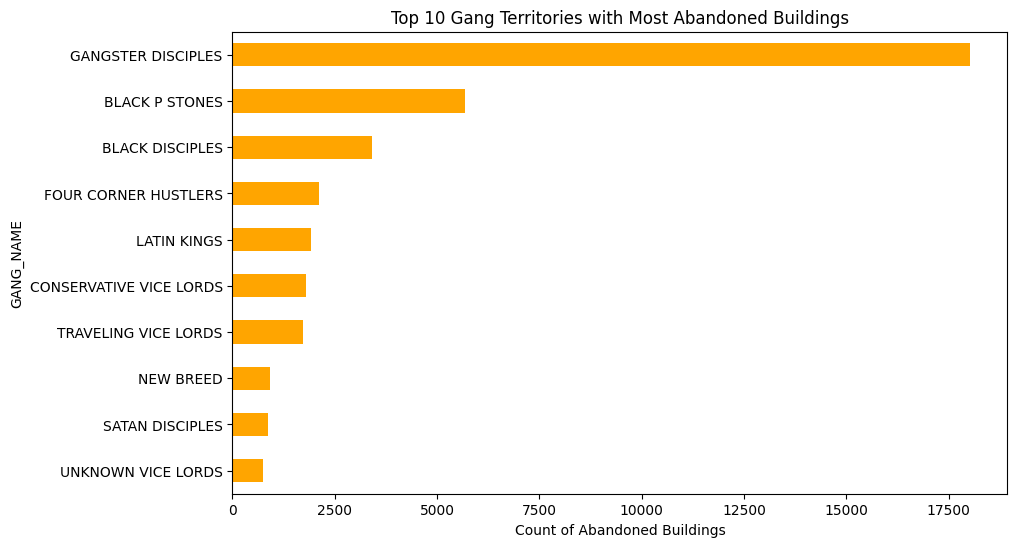

In [17]:
# Load Data
buildings_file = '311_Chicago_abandoned_buildings.csv'
# Read csv, assume reasonable encoding
buildings_df = pd.read_csv(buildings_file)

# Filter for valid location
buildings_df = buildings_df.dropna(subset=['LATITUDE', 'LONGITUDE'])

# Create GeoDataFrame
geometry_b = [Point(xy) for xy in zip(buildings_df['LONGITUDE'], buildings_df['LATITUDE'])]
buildings_gdf = gpd.GeoDataFrame(buildings_df, crs="EPSG:4326", geometry=geometry_b)

# Spatial Join with Gang Territories
if gangs_gdf.crs != buildings_gdf.crs:
    buildings_gdf = buildings_gdf.to_crs(gangs_gdf.crs)

buildings_in_gangs = gpd.sjoin(buildings_gdf, gangs_gdf, how='left', predicate='within')

# Label: In Gang Territory vs Outside
buildings_in_gangs['location_status'] = buildings_in_gangs['GANG_NAME'].apply(lambda x: 'Inside Gang Territory' if pd.notnull(x) else 'Outside')

# Analyze Counts and Percentages
status_counts = buildings_in_gangs['location_status'].value_counts().reset_index()
status_counts.columns = ['Location', 'Count']
status_counts['Percentage'] = (status_counts['Count'] / status_counts['Count'].sum()) * 100

print("Abandoned Buildings Location Analysis:")
print(status_counts)

# Bar Chart
plt.figure(figsize=(8, 6))
# Re-plotting from dataframe
plt.bar(status_counts['Location'], status_counts['Count'], color=['firebrick', 'gray'])
plt.title('Abandoned Buildings: Inside vs Outside Gang Territories')
plt.ylabel('Count')
for i, v in enumerate(status_counts['Count']):
    plt.text(i, v + 50, f"{v} ({status_counts['Percentage'][i]:.1f}%)", ha='center', fontweight='bold')
plt.show()

# Top Gangs by Abandoned Buildings
gang_b_counts = buildings_in_gangs[buildings_in_gangs['location_status'] == 'Inside Gang Territory']['GANG_NAME'].value_counts().head(10)
plt.figure(figsize=(10, 6))
gang_b_counts.sort_values().plot(kind='barh', color='orange')
plt.title('Top 10 Gang Territories with Most Abandoned Buildings')
plt.xlabel('Count of Abandoned Buildings')
plt.show()


Despite gang territories making up around 26% of the Chicago's territory, these neighborhoods account for 64% of the city's abandoned buildings. Showing systemic disinvestment and citizens fleeing these neighborhoods further spiraling these neighborhoods decline.

# 11. Education Performance Correlation
Analyzing school performance metrics in relation to gang territories.

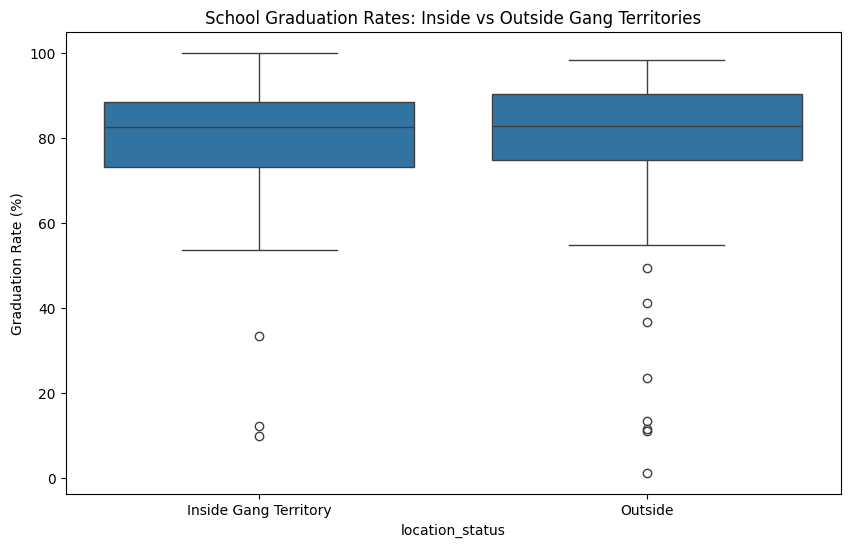

Mean Graduation Rate by Status:
location_status
Inside Gang Territory    77.017391
Outside                  78.273913
Name: Graduation_Rate_Clean, dtype: float64


In [18]:
# Load Data
schools_file = 'CPS23-24performancedata.csv'
schools_df = pd.read_csv(schools_file)

# Filter valid coords
schools_df = schools_df.dropna(subset=['School_Latitude', 'School_Longitude'])

# Create GeoDataFrame
geometry_s = [Point(xy) for xy in zip(schools_df['School_Longitude'], schools_df['School_Latitude'])]
schools_gdf = gpd.GeoDataFrame(schools_df, crs="EPSG:4326", geometry=geometry_s)

# Spatial Join
if gangs_gdf.crs != schools_gdf.crs:
    schools_gdf = schools_gdf.to_crs(gangs_gdf.crs)

schools_in_gangs = gpd.sjoin(schools_gdf, gangs_gdf, how='left', predicate='within')
schools_in_gangs['location_status'] = schools_in_gangs['GANG_NAME'].apply(lambda x: 'Inside Gang Territory' if pd.notnull(x) else 'Outside')

# Clean Graduation Rate (remove % and convert to float)
def clean_percent(x):
    if isinstance(x, str):
        try:
            return float(x.replace('%', ''))
        except ValueError:
            return None
    return x

if 'Graduation_Rate_School' in schools_in_gangs.columns:
    schools_in_gangs['Graduation_Rate_Clean'] = schools_in_gangs['Graduation_Rate_School'].apply(clean_percent)
    
    # Visualization: Graduation Rates
    import seaborn as sns
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='location_status', y='Graduation_Rate_Clean', data=schools_in_gangs)
    plt.title('School Graduation Rates: Inside vs Outside Gang Territories')
    plt.ylabel('Graduation Rate (%)')
    plt.show()
    
    print("Mean Graduation Rate by Status:")
    print(schools_in_gangs.groupby('location_status')['Graduation_Rate_Clean'].mean())
else:
    print("Graduation_Rate_School column not found.")


While the box plot shows subtle differences between the two groups, high schools outisde of gang territory have a higher median school graduation rate, 25th percentile school graduation rate, and 75th percentile school graduation rate than those in gang territory. However the minimum graduation rate for high schools in gang territory is higher than the minimum graduation rate for high schools outside of gang territory, and the maximum graduation rate for high schools in gang territory is higher than the maximum graduation rate for high schools outside of gang territory.